In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from tqdm import tqdm

%matplotlib inline

#每次可以输出多个变量
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import warnings
warnings.filterwarnings("ignore")

#中文字体
import matplotlib
matplotlib.use('qt4agg')
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

# XGB 历史数据

In [2]:
train = pd.read_csv('train_preprocessing34.csv')

train.shape
train.head()

(278894, 151)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,item_category_split,item_property_split,predict_category_property_split,item_category_split_count,item_property_split_count,time,day,hour,minute,user_query_day,user_query_day_hour,user_query_minute,user_shop_count,user_item_count,user_context_count,user_shop_trade_count,user_item_trade_count,user_context_trade_count,user_brand_count,user_city_count,user_brand_trade_count,user_city_trade_count,item_occupation_count,item_age_count,item_gender_count,item_occupation_trade_count,item_age_trade_count,item_gender_trade_count,shop_score,item_score,item_score2,item_score3,predict_category_split,predict_property_split,pred_category_split_count,pred_property_split_count,item_pred_category_score,item_pred_property_score,item_pred_category_score_item%,item_pred_property_score_item%,item_pred_category_score_pred%,item_pred_property_score_pred%,item_hot,user_hot,shop_hot,brand_hot,occupation_hot,city_hot,item_trade_hot,user_trade_hot,shop_trade_hot,brand_trade_hot,occupation_trade_hot,city_trade_hot,user_sell_power,user_sell_power_mean,user_sell_power_mean_item_minus,user_sell_trade_power,user_sell_trade_power_mean,user_sell_trade_power_mean_item_minus,yesterday,yesterhour,user_day_query,user_yesterday_query,user_hour_query,user_yesterhour_query,user_minute_query,item_day_query,item_hour_query,item_minute_query,user_item_day_query,user_item_hour_query,user_item_minute_query,min_time,user_is_his,item_is_his,brand_is_his,user_is_trade_his,item_is_trade_his,brand_is_trade_his,user_count,user_day_count,user_hour_count,user_minute_count,item_trade_percent,brand_trade_percent,user_trade_percent,occupation_trade_percent,is_home,shop_item_count,brand_item_count,city_brand_count,city_item_count,shop_item_count_his,brand_item_count_his,city_brand_count_his,city_item_count_his,item_id_idx,user_id_idx,shop_id_idx,item_brand_id_idx,item_city_id_idx,user_next_count,user_last_count,user_next_time,user_last_time,next_time_sub,last_time_sub,user_item_num,user_shop_num,user_item_day_num,user_shop_day_num,user_item_num_next,user_item_num_last,user_shop_num_next,user_shop_num_last,user_item_next_time,user_item_last_time,user_shop_next_time,user_shop_last_time,user_item_next_time_sub,user_item_last_time_sub,user_shop_next_time_sub,user_shop_last_time_sub
0,4293715837363757697,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,4,4,14,8711326521450559534,0,1000,2005,3003,5035994110420503338,1537465939,1,5799347067982556520:9172976955054793469;725801...,6765930309048922341,4,1.000000,3,1.000000,1.000000,1.000000,0,"['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...","[['5799347067982556520', '9172976955054793469'...",2,21,2018-09-21 01:52:19,21,1,55,9,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,6.0,0.0,0.0,0.0,7.000000,60,20.000,10.000000,"['5799347067982556520', '7258015885215914736',...","['9172976955054793469', '9172976955054793469']",5,2,2,1,6.666667,0.454545,3.333333,3.333333,12.0,0.0,12.0,50.0,137467,25252.0,0.0,0.0,0.0,0.0,2611,429.0,0.0,0.0,3.0,0.0,0.0,3.0,20,0,9,0.0,1,0.0,1,1,1,1,1,1,1,3.0,1,0,1,1,1,1,0,0,0,0,0.000000,0.000000,0.0,1.899365,0,1,7,224,1014,1.0,13.0,204.0,968.0,2654,123470,1907,390,28,1,-1,2018-09-21 04:30:26,NaN,9487,999999,0,0,0,0,1,-1,1,-1,2018-09-21 04:30:26,NaN,2018-09-21 04:30:26,NaN,9487,999999,9487,999999
1,70764105903083828,285660928590172217,7908382889764677758;8277336076276184272,2072967855524022579;5131280576272319091;263639...,90571032017349

In [201]:
# [
#     'item_category_split_count', 'item_property_split_count', 'day', 'hour',
#     'minute', 'user_shop_count', 'user_item_count', 'user_context_count',
#     'user_shop_trade_count', 'user_item_trade_count',
#     'user_context_trade_count', 'user_brand_count', 'user_city_count',
#     'user_brand_trade_count', 'user_city_trade_count', 'item_occupation_count',
#     'item_age_count', 'item_gender_count', 'item_occupation_trade_count',
#     'item_age_trade_count', 'item_gender_trade_count', 'shop_score',
#     'item_score', 'item_score2', 'item_score3', 'pred_category_split_count',
#     'pred_property_split_count', 'item_pred_category_score',
#     'item_pred_property_score', 'item_pred_category_score_item%',
#     'item_pred_property_score_item%', 'item_pred_category_score_pred%',
#     'item_pred_property_score_pred%', 'item_hot', 'user_hot', 'shop_hot',
#     'brand_hot', 'occupation_hot', 'city_hot', 'item_trade_hot',
#     'user_trade_hot', 'shop_trade_hot', 'brand_trade_hot',
#     'occupation_trade_hot', 'city_trade_hot', 'user_sell_power',
#     'user_sell_power_mean', 'user_sell_power_mean_item_minus',
#     'user_sell_trade_power', 'user_sell_trade_power_mean',
#     'user_sell_trade_power_mean_item_minus', 'yesterday', 'yesterhour',
#     'user_day_query', 'user_yesterday_query', 'user_hour_query',
#     'user_yesterhour_query', 'user_minute_query', 'item_day_query',
#     'item_hour_query', 'user_item_day_query', 'user_item_hour_query',
#     'item_minute_query', 'user_item_minute_query', 'user_count',
#     'user_day_count', 'user_hour_count', 'user_minute_count', 'min_time',
#     'user_is_his', 'item_is_his', 'brand_is_his', 'user_is_trade_his',
#     'item_is_trade_his', 'brand_is_trade_his', 'item_trade_percent',
#     'brand_trade_percent', 'user_trade_percent', 'occupation_trade_percent',
#     'is_home', 'shop_item_count', 'brand_item_count', 'city_brand_count',
#     'city_item_count', 'shop_item_count_his', 'brand_item_count_his',
#     'city_brand_count_his', 'city_item_count_his', 'item_id_idx',
#     'user_id_idx', 'shop_id_idx', 'item_brand_id_idx', 'item_city_id_idx',
#     'next_time_sub', 'last_time_sub', 'user_item_num', 'user_shop_num',
#     'user_item_day_num', 'user_shop_day_num'
# ]
# [
#     'item_category_split_count', 'day', 'hour', 'minute', 'user_shop_count',
#     'user_item_count', 'user_context_count', 'user_shop_trade_count',
#     'user_item_trade_count', 'user_context_trade_count', 'user_brand_count',
#     'user_city_count', 'user_city_trade_count', 'item_gender_count',
#     'item_occupation_trade_count', 'item_age_trade_count', 'shop_score',
#     'item_score2', 'item_score3', 'pred_category_split_count',
#     'pred_property_split_count', 'item_pred_category_score',
#     'item_pred_property_score', 'item_pred_category_score_item%',
#     'item_pred_property_score_pred%', 'item_hot', 'user_hot', 'shop_hot',
#     'brand_hot', 'occupation_hot', 'city_hot', 'user_trade_hot',
#     'shop_trade_hot', 'occupation_trade_hot', 'city_trade_hot',
#     'user_sell_power', 'user_sell_power_mean',
#     'user_sell_power_mean_item_minus', 'user_sell_trade_power',
#     'user_sell_trade_power_mean_item_minus', 'yesterday', 'yesterhour',
#     'user_day_query', 'user_yesterday_query', 'user_hour_query',
#     'user_minute_query', 'user_item_day_query', 'user_item_hour_query',
#     'item_minute_query', 'user_item_minute_query', 'user_count',
#     'user_day_count', 'user_hour_count', 'user_minute_count', 'user_is_his',
#     'brand_is_his', 'user_is_trade_his', 'item_is_trade_his',
#     'brand_is_trade_his', 'user_trade_percent', 'occupation_trade_percent',
#     'is_home', 'brand_item_count', 'city_brand_count', 'city_item_count',
#     'city_brand_count_his', 'city_item_count_his'
# ]

In [4]:
len(predictors)

103

In [3]:
origin = [
    'item_price_level', 'item_sales_level', 'item_collected_level',
    'item_pv_level', 'user_gender_id', 'user_age_level', 'user_occupation_id',
    'user_star_level', 'context_page_id', 'shop_review_num_level',
    'shop_review_positive_rate', 'shop_star_level', 'shop_score_service',
    'shop_score_delivery', 'shop_score_description'
]

predictors = [
    'item_category_split_count', 'item_property_split_count', 'day', 'hour',
    'minute', 'user_shop_count', 'user_item_count', 'user_context_count',
    'user_shop_trade_count', 'user_item_trade_count',
    'user_context_trade_count', 'user_brand_count', 'user_city_count',
    'user_brand_trade_count', 'user_city_trade_count', 'item_occupation_count',
    'item_age_count', 'item_gender_count', 'item_occupation_trade_count',
    'item_age_trade_count', 'item_gender_trade_count', 'shop_score',
    'item_score', 'item_score2', 'item_score3', 'pred_category_split_count',
    'pred_property_split_count', 'item_pred_category_score',
    'item_pred_property_score', 'item_pred_category_score_item%',
    'item_pred_property_score_item%', 'item_pred_category_score_pred%',
    'item_pred_property_score_pred%', 'item_hot', 'user_hot', 'shop_hot',
    'brand_hot', 'occupation_hot', 'city_hot', 'item_trade_hot',
    'user_trade_hot', 'shop_trade_hot', 'brand_trade_hot',
    'occupation_trade_hot', 'city_trade_hot', 'user_sell_power',
    'user_sell_power_mean', 'user_sell_power_mean_item_minus',
    'user_sell_trade_power', 'user_sell_trade_power_mean',
    'user_sell_trade_power_mean_item_minus', 'yesterday', 'yesterhour',
    'user_day_query', 'user_yesterday_query', 'user_hour_query',
    'user_yesterhour_query', 'user_minute_query', 'item_day_query',
    'item_hour_query', 'user_item_day_query', 'user_item_hour_query',
    'item_minute_query', 'user_item_minute_query', 'user_count',
    'user_day_count', 'user_hour_count', 'user_minute_count', 'min_time',
    'user_is_his', 'item_is_his', 'brand_is_his', 'user_is_trade_his',
    'item_is_trade_his', 'brand_is_trade_his', 'item_trade_percent',
    'brand_trade_percent', 'user_trade_percent', 'occupation_trade_percent',
    'is_home', 'shop_item_count', 'brand_item_count', 'city_brand_count',
    'city_item_count', 'shop_item_count_his', 'brand_item_count_his',
    'city_brand_count_his', 'city_item_count_his', 'item_id_idx',
    'user_id_idx', 'shop_id_idx', 'item_brand_id_idx', 'item_city_id_idx',
    'next_time_sub', 'last_time_sub', 'user_item_num', 'user_shop_num',
    'user_item_day_num', 'user_shop_day_num', 'user_item_next_time_sub',
    'user_item_last_time_sub', 'user_shop_next_time_sub',
    'user_shop_last_time_sub'
]

predictors_noleak = [
    'item_category_split_count', 'day', 'hour', 'minute', 'user_shop_count',
    'user_item_count', 'user_context_count', 'user_shop_trade_count',
    'user_item_trade_count', 'user_context_trade_count', 'user_brand_count',
    'user_city_count', 'user_city_trade_count', 'item_gender_count',
    'item_occupation_trade_count', 'item_age_trade_count', 'shop_score',
    'item_score2', 'item_score3', 'pred_category_split_count',
    'pred_property_split_count', 'item_pred_category_score',
    'item_pred_property_score', 'item_pred_category_score_item%',
    'item_pred_property_score_pred%', 'item_hot', 'user_hot', 'shop_hot',
    'brand_hot', 'occupation_hot', 'city_hot', 'user_trade_hot',
    'shop_trade_hot', 'occupation_trade_hot', 'city_trade_hot',
    'user_sell_power', 'user_sell_power_mean',
    'user_sell_power_mean_item_minus', 'user_sell_trade_power',
    'user_sell_trade_power_mean_item_minus', 'yesterday', 'yesterhour',
    'user_day_query', 'user_yesterday_query', 'user_hour_query',
    'user_minute_query', 'user_item_day_query', 'user_item_hour_query',
    'item_minute_query', 'user_item_minute_query', 'user_count',
    'user_day_count', 'user_hour_count', 'user_minute_count', 'user_is_his',
    'brand_is_his', 'user_is_trade_his', 'item_is_trade_his',
    'brand_is_trade_his', 'user_trade_percent', 'occupation_trade_percent',
    'is_home', 'brand_item_count', 'city_brand_count', 'city_item_count',
    'city_brand_count_his', 'city_item_count_his'
]

target = ['is_trade']

In [56]:
#onehot
onehot = ['user_gender_id', 'user_occupation_id', 'user_age_level']

drop = set(list(train.columns)) - set(predictors)
train = train.drop(drop, axis=1)
train = pd.get_dummies(train, columns=onehot)

In [5]:
import sys
sys.path.append('/Users/zero/xgboost/python-package')
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

C:\Users\ZERO\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
test = train[train.is_trade == -1]
val = train[(train.is_trade != -1) & (train.day == 24)]
train = train[(train.is_trade != -1) & (train.day != 24)]

train.shape
val.shape
test.shape

(203112, 151)

(57411, 151)

(18371, 151)

In [7]:
def remove_out_shop(train, test):
    trainid = {}
    testid = {}
    for shop_id in train.shop_id.values:
        trainid[shop_id] = trainid.get(shop_id, 0) + 1
    for shop_id in test.shop_id.values:
        testid[shop_id] = testid.get(shop_id, 0) + 1
    select_id = []
    for key in trainid:
        if (trainid[key] == 1) and (testid.get(key, 0) == 0):
            select_id.append(key)
    return select_id


train = train[~train.shop_id.isin(remove_out_shop(train, test))]

In [7]:
len(origin)
len(predictors)

predictors = list(set(origin + predictors))
predictors = list(set(predictors) - set(rubbish_features))
len(predictors)

15

118

NameError: name 'rubbish_features' is not defined

0.0811152548446


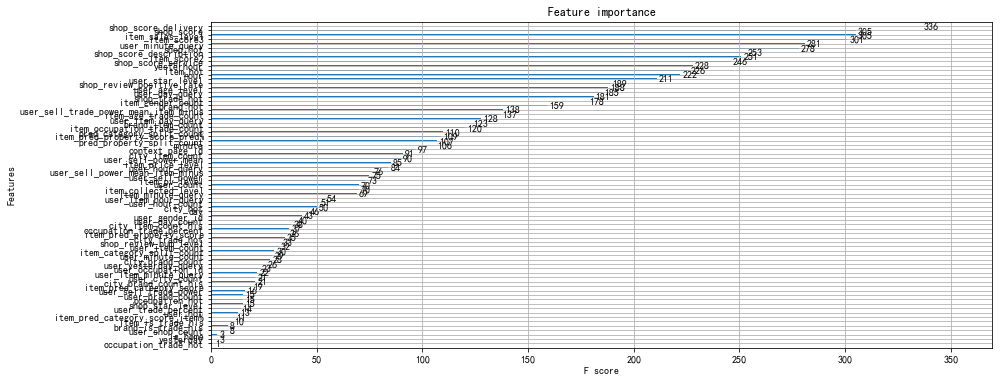

In [9]:
#train/val
params = {
    'objective': 'binary:logistic',
    'eta': 0.04,
    'colsample_bytree': 0.886,
    'min_child_weight': 1.6,
    'max_depth': 4,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
}

predictors = list(set(origin + predictors))
predictors = list(set(predictors) - set(rubbish_features))
xgbtrain = xgb.DMatrix(train[predictors], train[target])
xgbval = xgb.DMatrix(val[predictors])
model = xgb.train(params, xgbtrain, num_boost_round=560)
y_pred = model.predict(xgbval)
y_pred = pd.Series(y_pred, name='val')

print(log_loss(val[target], y_pred))
# 0.0813627345225(全部) 0.0812007377677(有效特征)
xgb.plot_importance(model)
#0.0810017960511(最好参数)0.04*560 无leak
#0.0797300048158 0.04*500 leak

In [211]:
#去掉不重要的特征
all_features = model.get_score()
unimportant_features = []
for item in enumerate(
        sorted(all_features.items(), key=lambda x: x[1], reverse=True)[-9:]):
    unimportant_features.append(item[1][0])
predictors = list(set(predictors) - set(unimportant_features))
len(predictors)
unimportant_features

81

['user_sell_trade_power',
 'user_city_count',
 'user_shop_count',
 'city_item_count',
 'occupation_hot',
 'user_brand_count',
 'occupation_trade_hot',
 'city_brand_count_his',
 'user_hot']

In [200]:
train.shape
val.shape
test.shape

(203112, 151)

(57411, 151)

(18371, 151)

In [10]:
#train/test
params = {
    'objective': 'binary:logistic',
    'eta': 0.04,
    'colsample_bytree': 0.886,
    'min_child_weight': 1.6,
    'max_depth': 4,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
}

predictors = list(set(origin + predictors_noleak))
# predictors = list(set(predictors) - set(rubbish_features))

train = pd.concat([train, val])
xgbtrain = xgb.DMatrix(train[predictors], train[target])
model = xgb.train(params, xgbtrain, num_boost_round=560)

xgbtest = xgb.DMatrix(test[predictors])
y_pred = model.predict(xgbtest)

idx = test.instance_id.reset_index()
idx['predicted_score'] = y_pred
idx[['instance_id', 'predicted_score']].to_csv(
    'resultWithHistory.txt',
    sep=' ',
    header=['instance_id', 'predicted_score'],
    index=False)

In [49]:
# 0.0816262372061(3:4):87
params = {
    'objective': 'binary:logistic',
    'eta': 0.07,
    'colsample_bytree': 0.886,
    'min_child_weight': 0.1,
    'max_depth': 5,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
} * 210
# 0.0811316881227(3:4):101 mac
params = {
    'objective': 'binary:logistic',
    'eta': 0.03,
    'colsample_bytree': 0.886,
    'min_child_weight': 0.2,
    'max_depth': 5,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
} * 550
# 0.0811539451487(3:4):101 windows
params = {
    'objective': 'binary:logistic',
    'eta': 0.03,
    'colsample_bytree': 0.886,
    'min_child_weight': 1.0,
    'max_depth': 4,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
} * 550
# 0.0810381300404(3:4)
params = {
    'objective': 'binary:logistic',
    'eta': 0.06,
    'colsample_bytree': 0.886,
    'min_child_weight': 2.0,
    'max_depth': 4,
    'subsample': 0.886,
    'gamma': 0.05,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
} * 265

# 特征筛选

In [7]:
params = {
    'objective': 'binary:logistic',
    'eta': 0.04,
    'colsample_bytree': 0.886,
    'min_child_weight': 1.6,
    'max_depth': 4,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
}

feature_performance = {}

for i in predictors:
    temp_features = origin.copy()
    temp_features.append(i)
    xgbtrain = xgb.DMatrix(train[temp_features], train[target])
    xgbval = xgb.DMatrix(val[temp_features])
    model = xgb.train(params, xgbtrain, num_boost_round=625)
    y_pred = model.predict(xgbval)
    y_pred = pd.Series(y_pred, name='val')

    print(str(i) + ':' + str(log_loss(val[target], y_pred)))
    feature_performance[i] = log_loss(val[target], y_pred)

item_category_split_count:0.0822522488521
item_property_split_count:0.0822683362851
day:0.0822259580054
hour:0.0822986489861
minute:0.0822332651485
user_shop_count:0.0822878768264
user_item_count:0.082235603914
user_context_count:0.0822238284936
user_shop_trade_count:0.0822238284936
user_item_trade_count:0.0822238284936
user_context_trade_count:0.0822238284936
user_brand_count:0.0822586828332
user_city_count:0.082269515899
user_brand_trade_count:0.0822238284936
user_city_trade_count:0.0822535664787
item_occupation_count:0.0823152186365
item_age_count:0.0823426937125
item_gender_count:0.0822403843191
item_occupation_trade_count:0.082269457111
item_age_trade_count:0.0822357415337
item_gender_trade_count:0.0823041900576
shop_score:0.0822773422105
item_score:0.0822631385963
item_score2:0.0822605169975
item_score3:0.0822707607956
pred_category_split_count:0.0823258996296
pred_property_split_count:0.0822464834169
item_pred_category_score:0.0822000584069
item_pred_property_score:0.08225816080

In [153]:
sorted(feature_performance.items(), key=lambda x: x[1])

[('next_time_sub', 0.081262828805773443),
 ('last_time_sub', 0.081449333284086739),
 ('user_minute_query', 0.081617401189738092),
 ('user_hour_query', 0.08179279500837737),
 ('user_day_query', 0.081838306355686272),
 ('user_minute_count', 0.082012019586114107),
 ('user_hour_count', 0.08201614234089423),
 ('user_day_count', 0.08203163533406839),
 ('user_item_num', 0.082086068801853332),
 ('item_minute_query', 0.082100417958137273),
 ('user_sell_power_mean', 0.082140764262911142),
 ('user_shop_num', 0.082143560233487081),
 ('shop_hot', 0.082146203082871197),
 ('city_item_count_his', 0.08215012251662189),
 ('user_hot', 0.082153734743192222),
 ('yesterhour', 0.082159866933395095),
 ('user_count', 0.082172580101764911),
 ('user_item_day_query', 0.082173932248271006),
 ('user_yesterday_query', 0.082177626963099368),
 ('item_pred_property_score_pred%', 0.082185051628517414),
 ('city_item_count', 0.082189112753539989),
 ('user_item_hour_query', 0.082189690654722022),
 ('user_item_day_num', 0.0

In [193]:
rubbish_features = []

for i in enumerate(feature_performance):
    if feature_performance[i[1]] > 0.0823237496341:
        rubbish_features.append(i[1])
len(rubbish_features)

11

In [ ]:
origin: 0.0823679693772
origin + predictors: 0.0813627345225

# XGB 无历史数据

In [228]:
df = pd.read_csv('df_without_his.csv')

df.shape
df.head()

(496509, 68)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,time,day,hour,user_query_day,user_query_day_hour,shop_score,item_score,item_score2,item_score3,predict_category_property_split,predict_category_split,predict_property_split,item_category_split,item_property_split,item_category_split_count,item_property_split_count,predict_category_property_split_count,pred_category_split_count,pred_property_split_count,item_pred_category_score,item_pred_property_score,item_pred_category_score_item%,item_pred_property_score_item%,item_pred_category_score_pred%,item_pred_property_score_pred%,yesterday,yesterhour,user_day_query,user_yesterday_query,user_hour_query,user_yesterhour_query,minute,user_query_minute,item_day_query,item_hour_query,user_item_day_query,min_time,user_item_hour_query,user_minute_query,item_minute_query,user_item_minute_query
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,4505772604969228686,1,1003,2005,3003,282924576738839389,1537236544,5,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 10:09:04,18,10,3,3,7.0,59,19.666667,3.277778,"['5799347067982556520:-1', '509660095530134768...","['5799347067982556520', '509660095530134768', ...",['9148482949976129397'],"['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,5,5,1,2,0,6.666667,0.000000,3.333333,0.000000,17,9,3,0.0,3,0.0,5,1,6,2,1,20.0,1,1,1,1
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2692638157208937547,0,1002,2005,3006,4007979028023783431,1537243232,0,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 12:00:32,18,12,8,5,7.0,59,19.666667,19.666667,"['5799347067982556520:9172976955054793469', '7...","['5799347067982556520', '7908382889764677758']","['9172976955054793469', '1787573075717641245,9...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,2,2,2,2,1,6.666667,0.434783,6.666667,3.333333,17,11,8,0.0,5,1.0,5,4,6,1,1,24.0,1,4,1,1
2,842679481291040981,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,5247924392014515924,0,1003,2005,3004,4884875192608989870,1537211052,0,5799347067982556520:5131280576272319091;725801...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 03:04:12,18,3,2,2,7.0,59,19.666667,19.666667,"['5799347067982556520:5131280576272319091', '7...","['5799347067982556520', '7258015885215914736',...","['5131280576272319091', '5131280576272319091',...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,3,3,3,2,1,6.666667,0.434783,5.000000,2.500000,17,2,2,0.0,2,0.0,5,2,6,2,1,6.0,1,2,1,1
3,937088850059189027,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2681414445369714628,1,1004,2005,3006,840119421106178602,1537222670,15,509660095530134768:-1;5799347067982556520:-1;7...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 06:17:50,18,6,1,1,7.0,59,19.666667,1.229167,"['509660095530134768:-1', '5799347067982556520...","['509660095530134768', '5799347067982556520', ...","['1787573075717641245,9148482949976129397', '9...","['79083

In [229]:
origin = [
    'item_price_level', 'item_sales_level', 'item_collected_level',
    'item_pv_level', 'user_gender_id', 'user_age_level', 'user_occupation_id',
    'user_star_level', 'context_page_id', 'shop_review_num_level',
    'shop_review_positive_rate', 'shop_star_level', 'shop_score_service',
    'shop_score_delivery', 'shop_score_description'
]

predictors = [
    'item_category_split_count', 'item_property_split_count', 'day', 'hour',
    'minute', 'user_shop_count', 'user_item_count', 'user_shop_trade_count',
    'user_item_trade_count', 'user_brand_count', 'user_city_count',
    'user_brand_trade_count', 'user_city_trade_count', 'item_occupation_count',
    'item_age_count', 'item_gender_count', 'item_occupation_trade_count',
    'item_age_trade_count', 'item_gender_trade_count', 'shop_score',
    'item_score', 'item_score2', 'item_score3', 'pred_category_split_count',
    'pred_property_split_count', 'item_pred_category_score',
    'item_pred_property_score', 'item_hot', 'user_hot', 'shop_hot',
    'brand_hot', 'occupation_hot', 'city_hot', 'item_trade_hot',
    'user_trade_hot', 'shop_trade_hot', 'brand_trade_hot',
    'occupation_trade_hot', 'city_trade_hot', 'user_sell_power',
    'user_sell_power_mean', 'user_sell_power_mean_item_minus',
    'user_sell_trade_power', 'user_sell_trade_power_mean',
    'user_sell_trade_power_mean_item_minus', 'user_day_query',
    'user_yesterday_query', 'user_hour_query', 'user_yesterhour_query',
    'user_minute_query', 'item_day_query', 'item_hour_query',
    'user_item_day_query', 'user_item_hour_query', 'item_minute_query',
    'user_item_minute_query', 'user_count', 'user_day_count',
    'user_hour_count', 'user_minute_count', 'min_time', 'is_home',
    'shop_item_count', 'brand_item_count', 'city_brand_count',
    'city_item_count', 'shop_item_count_his', 'brand_item_count_his',
    'city_brand_count_his', 'city_item_count_his', 'item_id_idx',
    'user_id_idx', 'shop_id_idx', 'item_brand_id_idx', 'item_city_id_idx'
]

target = ['is_trade']

In [230]:
y_train = df[(df.day != 24) & (df.is_trade != -1)][target]
x_train = df[(df.day != 24) & (df.is_trade != -1)][origin]

y_val = df[(df.day == 24) & (df.is_trade != -1)][target]
x_val = df[(df.day == 24) & (df.is_trade != -1)][origin]

y_test = df[df.is_trade == -1][target]
x_test = df[df.is_trade == -1][origin]
idx = df[df.is_trade == -1].instance_id.reset_index()

x_train.shape
x_val.shape
x_test.shape

del df

#(420717, 33)
#(57421, 33)
#(18371, 33)

(420717, 15)

(57421, 15)

(18371, 15)

In [231]:
import sys
sys.path.append('/Users/zero/xgboost/python-package')
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

0.0825266757716


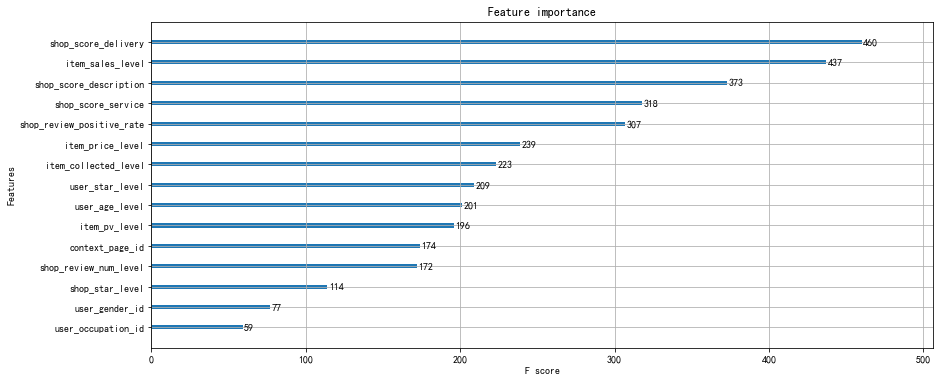

In [234]:
params = {
    'objective': 'binary:logistic',
    'eta': 0.06,
    'colsample_bytree': 0.886,
    'min_child_weight': 2.0,
    'max_depth': 4,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
}

xgbtrain = xgb.DMatrix(x_train, y_train)
xgbval = xgb.DMatrix(x_val)
model = xgb.train(params, xgbtrain, num_boost_round=265)
y_pred = model.predict(xgbval)
y_pred = pd.Series(y_pred, name='val')

print(log_loss(y_val, y_pred))  # 0.0813534669374(46 Features)
xgb.plot_importance(model)

# xgbtest = xgb.DMatrix(x_test)
# y_pred = model.predict(xgbtest)

# idx['predicted_score'] = y_pred
# idx[['instance_id', 'predicted_score']].to_csv(
#     'resultWithoutHistory.txt',
#     sep=' ',
#     header=['instance_id', 'predicted_score'],
#     index=False)

In [ ]:
#33 Features(0.0816401133236/0.08293 )
#46 Features(0.0813534669374/0.08265)

# lgb试一下

In [35]:
import lightgbm as lgb
from sklearn.metrics import log_loss
import gc

In [138]:
df = pd.read_csv('df_without_his.csv')

df.shape
df.head()

(496509, 52)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,time,day,hour,user_query_day,user_query_day_hour,shop_score,item_score,item_score2,item_score3,predict_category_property_split,predict_category_split,predict_property_split,item_category_split,item_property_split,item_category_split_count,item_property_split_count,predict_category_property_split_count,pred_category_split_count,pred_property_split_count,item_pred_category_score,item_pred_property_score,item_pred_category_score_item%,item_pred_property_score_item%,item_pred_category_score_pred%,item_pred_property_score_pred%
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,4505772604969228686,1,1003,2005,3003,282924576738839389,1537236544,5,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 10:09:04,18,10,3,3,7.0,59,19.666667,3.277778,"['5799347067982556520:-1', '509660095530134768...","['5799347067982556520', '509660095530134768', ...",['9148482949976129397'],"['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,5,5,1,2,0,6.666667,0.000000,3.333333,0.000000
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2692638157208937547,0,1002,2005,3006,4007979028023783431,1537243232,0,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 12:00:32,18,12,8,5,7.0,59,19.666667,19.666667,"['5799347067982556520:9172976955054793469', '7...","['5799347067982556520', '7908382889764677758']","['9172976955054793469', '1787573075717641245,9...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,2,2,2,2,1,6.666667,0.434783,6.666667,3.333333
2,842679481291040981,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,5247924392014515924,0,1003,2005,3004,4884875192608989870,1537211052,0,5799347067982556520:5131280576272319091;725801...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 03:04:12,18,3,2,2,7.0,59,19.666667,19.666667,"['5799347067982556520:5131280576272319091', '7...","['5799347067982556520', '7258015885215914736',...","['5131280576272319091', '5131280576272319091',...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,3,3,3,2,1,6.666667,0.434783,5.000000,2.500000
3,937088850059189027,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2681414445369714628,1,1004,2005,3006,840119421106178602,1537222670,15,509660095530134768:-1;5799347067982556520:-1;7...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 06:17:50,18,6,1,1,7.0,59,19.666667,1.229167,"['509660095530134768:-1', '5799347067982556520...","['509660095530134768', '5799347067982556520', ...","['1787573075717641245,9148482949976129397', '9...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,5,5,3,2,0,6.666667,0.000000,3.333333,0.000000
4,7975697065017708072,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2729475788342039013,0,1002,2005,3001,173676997171035468

In [139]:
y_train = df[(df.day != 24) & (df.is_trade != -1)][target]
x_train = df[(df.day != 24) & (df.is_trade != -1)][predictors]

y_val = df[(df.day == 24) & (df.is_trade != -1)][target]
x_val = df[(df.day == 24) & (df.is_trade != -1)][predictors]

y_test = df[df.is_trade == -1][target]
x_test = df[df.is_trade == -1][predictors]

x_train.shape
x_val.shape
x_test.shape

del df

(420717, 33)

(57421, 33)

(18371, 33)

In [122]:
#without history
clf = lgb.LGBMClassifier(
    learning_rate=0.07,
    colsample_bytree=1.0,
    num_leaves=50,
    max_depth=5,
    min_child_weight=0.1,
    n_estimators=400,
    n_jobs=20,
    reg_alpha=0.1,
    reg_lambda=0.1)
clf.fit(
    x_train,
    y_train,
    feature_name=predictors,
    categorical_feature=['user_gender_id', 'user_occupation_id'])
y_pred = clf.predict_proba(x_val)[:, 1]
print(log_loss(y_val, y_pred))  # 0.0817086630893
lgb.plot_importance(clf)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.07, max_depth=5, min_child_samples=20,
        min_child_weight=0.1, min_split_gain=0.0, n_estimators=400,
        n_jobs=20, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

0.081978292469


In [98]:
train = pd.read_csv('train_preprocessing52.csv')

train.shape
train.head()

(139406, 85)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,item_category_split,item_property_split,predict_category_property_split,item_category_split_count,item_property_split_count,time,day,hour,user_query_day,user_query_day_hour,user_shop_count,user_item_count,user_context_count,user_shop_trade_count,user_item_trade_count,user_context_trade_count,user_brand_count,user_city_count,user_brand_trade_count,user_city_trade_count,item_occupation_count,item_age_count,item_gender_count,item_occupation_trade_count,item_age_trade_count,item_gender_trade_count,shop_score,item_score,item_score2,item_score3,predict_category_split,predict_property_split,pred_category_split_count,pred_property_split_count,item_pred_category_score,item_pred_property_score,item_pred_category_score_item%,item_pred_property_score_item%,item_pred_category_score_pred%,item_pred_property_score_pred%,item_hot,user_hot,shop_hot,brand_hot,occupation_hot,city_hot,item_trade_hot,user_trade_hot,shop_trade_hot,brand_trade_hot,occupation_trade_hot,city_trade_hot,user_sell_power,user_sell_power_mean,user_sell_power_mean_item_minus,user_sell_trade_power,user_sell_trade_power_mean,user_sell_trade_power_mean_item_minus
0,1294180558417909525,3417228998968466891,7908382889764677758;5799347067982556520,2636395404473730413;4067341101015777832;101341...,1369755222868145421,5326000431362991708,7,1,4,8,4790424684324799775,0,1003,2002,3006,8843409125615638650,1537712904,0,"5799347067982556520:9172976955054793469,742282...",3011322251466986596,12,0.981125,10,0.974849,0.977525,0.966823,0,"['7908382889764677758', '5799347067982556520']","['2636395404473730413', '4067341101015777832',...","[['5799347067982556520', '9172976955054793469,...",2,14,2018-09-23 22:28:24,23,22,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,20.060442,33,4.714286,4.714286,"['5799347067982556520', '7908382889764677758']","['9172976955054793469,7422828355050797095', '7...",2,2,2,0,6.666667,0.0,6.666667,0.0,1.0,18.0,1.0,1.0,110154,1274,0.0,0.0,0.0,0.0,2306,35,111.0,5.842105,1.157895,0.0,0.0,7.0
1,4988669284857152533,932459418921071956,7908382889764677758;5755694407684602296,5131280576272319091;2636395404473730413;655689...,3101174666276603352,7322157373578955368,8,12,14,18,5297018676355586708,1,1004,2002,3005,5448626819385615379,1537703526,0,5755694407684602296:-1;7908382889764677758:-1;...,6244933171089048032,16,1.000000,15,0.963192,0.960966,0.983802,0,"['7908382889764677758', '5755694407684602296']","['5131280576272319091', '2636395404473730413',...","[['5755694407684602296', '-1'], ['790838288976...",2,49,2018-09-23 19:52:06,23,19,3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,79.0,84.0,3.0,3.0,3.0,28.228659,264,33.000000,33.000000,"['5755694407684602296', '7908382889764677758',...",[],4,0,2,0,6.666667,0.0,4.000000,0.0,292.0,0.0,375.0,645.0,110154,43204,7.0,0.0,8.0,17.0,2306,912,0.0,0.000000,8.000000,0.0,0.0,8.0
2,5378282568284173939,932459418921071956,7908382889764677758;5755694407684602296,5131280576272319091;2636395404473730413;655689...,3101174666276603352,7322157373578955368,8,12,14,18,2128349640379796295,0,1005,2005,3002,6454805461923703549,1537699469,0,2948160913626618607:4083958765544089731;264834...,6244933171089048032,16,1.000000,15,0.963192,0.960966,0.983802,0,"['7908382889764677758', '5755694407684602296']","['5131280576272319091', '2636395404473730413',...","[['2948160913626618607', '4083958765544089731'...",2,49,2018-09-23 18:44:29,23,18,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.0,48.0,193.0,4.0,1.0,4.0,28.228659,264,33.000000,33.000000,"['2948160913626618607', '2648343924459474923',...","['408

In [99]:
test = train[train.is_trade == -1]
val = train[(train.is_trade != -1) & (train.day == 24)]
train = train[(train.is_trade != -1) & (train.day == 23)]

train.shape
val.shape
test.shape

(63614, 85)

(57421, 85)

(18371, 85)

In [100]:
predictors = [
    'item_price_level', 'item_sales_level', 'item_collected_level',
    'item_pv_level', 'user_gender_id', 'user_age_level', 'user_occupation_id',
    'user_star_level', 'context_page_id', 'shop_review_num_level',
    'shop_review_positive_rate', 'shop_star_level', 'shop_score_service',
    'shop_score_delivery', 'shop_score_description',
    'item_category_split_count', 'item_property_split_count', 'day', 'hour',
    'user_query_day', 'user_query_day_hour', 'user_shop_count',
    'user_item_count', 'user_context_count', 'user_shop_trade_count',
    'user_item_trade_count', 'user_context_trade_count', 'user_brand_count',
    'user_city_count', 'user_brand_trade_count', 'user_city_trade_count',
    'item_occupation_count', 'item_age_count', 'item_gender_count',
    'item_occupation_trade_count', 'item_age_trade_count',
    'item_gender_trade_count', 'shop_score', 'item_score', 'item_score2',
    'item_score3', 'pred_category_split_count', 'pred_property_split_count',
    'item_pred_category_score', 'item_pred_property_score',
    'item_pred_category_score_item%', 'item_pred_property_score_item%',
    'item_pred_category_score_pred%', 'item_pred_property_score_pred%',
    'item_hot', 'user_hot', 'shop_hot', 'brand_hot', 'occupation_hot',
    'city_hot', 'item_trade_hot', 'user_trade_hot', 'shop_trade_hot',
    'brand_trade_hot', 'occupation_trade_hot', 'city_trade_hot',
    'user_sell_power', 'user_sell_power_mean',
    'user_sell_power_mean_item_minus', 'user_sell_trade_power',
    'user_sell_trade_power_mean', 'user_sell_trade_power_mean_item_minus'
]

target = ['is_trade']

In [109]:
#val
clf = lgb.LGBMClassifier(
    learning_rate=0.05,
    num_leaves=63,
    max_depth=5,
    min_child_weight=0.1,
    n_estimators=112,
    n_jobs=20,
    reg_alpha=0.1,
    reg_lambda=0.1)
clf.fit(
    train[predictors],
    train[target],
    feature_name=predictors,
    categorical_feature=['user_gender_id', 'user_occupation_id', 'day'])
y_val = clf.predict_proba(val[predictors])[:, 1]
print(log_loss(val[target], y_val))  # 0.0824696179375
lgb.plot_importance(clf)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.05, max_depth=5, min_child_samples=20,
        min_child_weight=0.1, min_split_gain=0.0, n_estimators=112,
        n_jobs=20, num_leaves=63, objective=None, random_state=None,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

0.0825322791568


In [90]:
#test
train = pd.concat([train, val])

clf = lgb.LGBMClassifier(
    learning_rate=0.05,
    num_leaves=63,
    max_depth=5,
    min_child_weight=0.1,
    n_estimators=112,
    n_jobs=20,
    reg_alpha=0.1,
    reg_lambda=0.1)
clf.fit(
    train[predictors],
    train[target],
    feature_name=predictors,
    categorical_feature=['user_gender_id', 'user_occupation_id', 'day'])
y_pred = clf.predict_proba(test[predictors])[:, 1]
test['predicted_score'] = y_pred

test[['instance_id', 'predicted_score']].to_csv(
    'resultWithHistory.txt',
    sep=' ',
    header=['instance_id', 'predicted_score'],
    index=None)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.05, max_depth=5, min_child_samples=20,
        min_child_weight=0.1, min_split_gain=0.0, n_estimators=112,
        n_jobs=20, num_leaves=63, objective=None, random_state=None,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)